In [1]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
import features_utility as featutil

## File Details - Content Filtering 2 - Tinkering with features

See wiki page on Hybrid and plan of attack. in 05 File, did a basic regression template process based on beer type and ABV. 

This one will tinker with different features, try to find a good combination based just on basic feature selection

Note, turned this one off with sub run file, as found adding the Review Count cols improved MAE (slightly)

In [2]:
filePrefix = "A3_060_lgbm_basicregression_feats_tinker"
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"
subrunDir = "subruns/"
writeSubRunFile = False
seed = databasic.get_random_seed()

In [3]:
# RowID  BeerID  ReviewerID  BeerName  BeerType  Label
# df_train = pd.read_csv(baseDataDir + 'train_500k.tsv',sep='\t',
df_train = pd.read_csv(baseDataDir + 'train_200k.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_train.head(10)

# df_vali = pd.read_csv(baseDataDir + 'vali_500k.tsv',sep='\t',
df_vali = pd.read_csv(baseDataDir + 'vali_200k.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_vali.head(10)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
0,22,12300,2634,Rauch �r Bock,Rauchbier,4.0
1,27,12300,5634,Rauch �r Bock,Rauchbier,4.5
2,28,12300,3544,Rauch �r Bock,Rauchbier,4.5
3,40,12300,6521,Rauch �r Bock,Rauchbier,4.0
4,43,12300,10177,Rauch �r Bock,Rauchbier,4.5
5,48,12300,2907,Rauch �r Bock,Rauchbier,3.5
6,49,12300,1532,Rauch �r Bock,Rauchbier,4.0
7,50,12300,3452,Rauch �r Bock,Rauchbier,3.5
8,59,12300,6861,Rauch �r Bock,Rauchbier,4.0
9,64,6699,6401,Caldera Pale Ale,American Pale Ale (APA),4.5


In [4]:
# RowID BrewerID ABV DayofWeek Month DayofMonth Year TimeOfDay Gender Birthday Text Lemmatized POS_Tag
# df_features = pd.read_csv(baseDataDir + 'features_500k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
df_features = pd.read_csv(baseDataDir + 'features_200k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
                                                                 'DayofMonth','Year','TimeOfDay','Gender',
                                                                 'Birthday','Text','Lemmatized','POS_Tag'])

df_features.head()

,RowID,BrewerID,ABV,DayofWeek,Month,DayofMonth,Year,TimeOfDay,Gender,Birthday,Text,Lemmatized,POS_Tag
0,18,1075,7.4,Mon,Jan,2,2012,15:20:04,Male,unknown,Pours a murky light brown with a 1 inch fizzy ...,pour a murky light brown with a 1 inch fizzy t...,VBZ DT JJ NN JJ IN DT CD NN JJ NN NN WDT VBZ I...
1,19,1075,7.4,Sun,Jan,1,2012,06:46:52,Male,unknown,Faint sudsy head with some with some dissipati...,faint sudsy head with some with some dissipate...,NN JJ NN IN DT IN DT VBG JJ NN . JJ JJ NN . DT...
2,20,1075,7.4,Tue,Nov,29,2011,05:51:44,Male,unknown,A new arrival to the West TN area ... Pours qu...,a new arrival to the West TN area ... pour qui...,"DT JJ NN IN DT NNP NNP NN , VBZ PDT DT NN JJR ..."
3,21,1075,7.4,Sat,Nov,5,2011,22:59:57,Male,unknown,Sampled 10/30/11 - Transferring the notes . A ...,sample 10/30/11 - transfer the note . a ruby p...,VBN CD HYPH VBG DT NNS . DT NN VBP IN DT NN NN...
4,22,1075,7.4,Tue,Nov,1,2011,20:40:21,Male,"Oct 14, 1983",This is my first rauchbier . Pours a burnt amb...,this be my first rauchbier . pour a burn amber...,DT VBZ PRP$ JJ NN . VBZ DT VBN NN . JJ NN . NN...


In [5]:
colsToUse = ["RowID", "BrewerID", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"]

# Find the feature records that match the training and validation data and join them together
dfFullData = df_train.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")
dfFullDataVali = df_vali.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")

dfFullData.head()

,RowID,BeerID,ReviewerID,BeerName,BeerType,rating,RowIDFeat,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay
0,19,12300,10635,Rauch �r Bock,Rauchbier,4.0,37,1075,7.4,Mon,23,May,2011,Male,15:36:28
1,21,12300,6547,Rauch �r Bock,Rauchbier,4.5,40,1075,7.4,Mon,16,May,2011,Male,00:31:46
2,23,12300,9789,Rauch �r Bock,Rauchbier,4.5,42,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26
3,24,12300,7372,Rauch �r Bock,Rauchbier,5.0,43,1075,7.4,Wed,30,Mar,2011,Male,14:08:00
4,25,12300,1302,Rauch �r Bock,Rauchbier,4.5,45,1075,7.4,Thu,24,Mar,2011,Male,14:07:00


In [6]:
# Remove the duplicated Row ID, also remove Beer Name at this point, we're nt using it
df_train_data = dfFullData.drop(['RowIDFeat', "BeerName"],axis=1)
df_vali_data = dfFullDataVali.drop(['RowIDFeat', "BeerName"],axis=1)

df_train_data.head()

,RowID,BeerID,ReviewerID,BeerType,rating,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay
0,19,12300,10635,Rauchbier,4.0,1075,7.4,Mon,23,May,2011,Male,15:36:28
1,21,12300,6547,Rauchbier,4.5,1075,7.4,Mon,16,May,2011,Male,00:31:46
2,23,12300,9789,Rauchbier,4.5,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26
3,24,12300,7372,Rauchbier,5.0,1075,7.4,Wed,30,Mar,2011,Male,14:08:00
4,25,12300,1302,Rauchbier,4.5,1075,7.4,Thu,24,Mar,2011,Male,14:07:00


In [7]:
print(df_train_data.shape)
print(df_vali_data.shape)

(106546, 13)
(35089, 13)


In [8]:
colsToUse.append("BeerType")

considerCol = {}

# Initialize them all to True, use all the cols
for colName in colsToUse:
  considerCol[colName] = True

# "RowID", "BrewerID", "BeerType", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"
# Disable any column we want

# Beer Context Columns
considerCol["ABV"] = False
considerCol["BrewerID"] = False
considerCol["BeerType"] = False

# Consumer Context Columns
# considerCol["DayofWeek"] = False
# considerCol["DayofMonth"] = False
# considerCol["Month"] = False
# considerCol["Year"] = False
# considerCol["TimeOfDay"] = False
# considerCol["Gender"] = False

In [9]:
if considerCol["ABV"] == False:
  del df_train_data["ABV"]
  del df_vali_data["ABV"]

In [10]:
if considerCol["BrewerID"] == False:
  del df_train_data["BrewerID"]
  del df_vali_data["BrewerID"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BrewerID")


In [11]:
if considerCol["BeerType"] == False:
  del df_train_data["BeerType"]
  del df_vali_data["BeerType"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BeerType")

In [12]:
if considerCol["Gender"] == False:
  del df_train_data["Gender"]
  del df_vali_data["Gender"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "Gender")

c:\Development\COSC2670\Assignment3\utilities\dataframe_utility.py:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_combined.columns = df_combined.columns.str.replace(" ", "").str.replace("/", "").str.replace("-", "") \


In [13]:
if considerCol["DayofWeek"] == False:
  del df_train_data["DayofWeek"]
  del df_vali_data["DayofWeek"]
else: 
  df_train_data = featutil.formatDayOfWeek(df_train_data)
  df_vali_data = featutil.formatDayOfWeek(df_vali_data)

In [14]:
if considerCol["Month"] == False:
  del df_train_data["Month"]
  del df_vali_data["Month"]
else: 
  df_train_data = featutil.formatMonth(df_train_data)
  df_vali_data = featutil.formatMonth(df_vali_data)

In [15]:
if considerCol["DayofMonth"] == False:
  del df_train_data["DayofMonth"]
  del df_vali_data["DayofMonth"]

In [16]:
if considerCol["Year"] == False:
  del df_train_data["Year"]
  del df_vali_data["Year"]

In [17]:
if considerCol["TimeOfDay"] == False:
  del df_train_data["TimeOfDay"]
  del df_vali_data["TimeOfDay"]
else: 
  df_train_data = featutil.formatTimeToSec(df_train_data)
  df_vali_data = featutil.formatTimeToSec(df_vali_data)

In [18]:
print(df_train_data.shape)
print(df_vali_data.shape)

df_train_data.head()

(106546, 12)
(106546, 12)


,RowID,BeerID,ReviewerID,rating,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,19,12300,10635,4.0,1,23,5,2011,56188,0,1,0
1,21,12300,6547,4.5,1,16,5,2011,1906,0,1,0
2,23,12300,9789,4.5,7,10,4,2011,44246,0,0,1
3,24,12300,7372,5.0,3,30,3,2011,50880,0,1,0
4,25,12300,1302,4.5,4,24,3,2011,50820,0,1,0


In [19]:
df_vali_data.head()

,RowID,BeerID,ReviewerID,rating,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,19,12300,10635,4.0,1,23,5,2011,56188,0,1,0
1,21,12300,6547,4.5,1,16,5,2011,1906,0,1,0
2,23,12300,9789,4.5,7,10,4,2011,44246,0,0,1
3,24,12300,7372,5.0,3,30,3,2011,50880,0,1,0
4,25,12300,1302,4.5,4,24,3,2011,50820,0,1,0


In [20]:
# free up the memory
del dfFullData
del dfFullDataVali

In [21]:
# Get all the columns
col_names = df_train_data.columns

idCols = ['RowID','BeerID','ReviewerID']
feature_cols =  col_names.drop(['RowID','BeerID','ReviewerID','rating' ])
target_col = 'rating'

# Create the sub data sets of the features and the target
dfTrainIds = df_train_data[idCols]
dfTrainFeatures = df_train_data[feature_cols]
dfTrainTarget = df_train_data[target_col]

dfValiIds = df_vali_data[idCols]
dfValiFeatures = df_vali_data[feature_cols]
dfValiTarget = df_vali_data[target_col]


In [22]:
print(dfTrainFeatures.shape)
dfTrainFeatures.head()

(106546, 8)


,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,1,23,5,2011,56188,0,1,0
1,1,16,5,2011,1906,0,1,0
2,7,10,4,2011,44246,0,0,1
3,3,30,3,2011,50880,0,1,0
4,4,24,3,2011,50820,0,1,0


In [23]:

# Create the Light GBM Regression model and train
model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed)
model.fit(X=dfTrainFeatures, y=dfTrainTarget, )

LGBMRegressor(metric='mae', objective='regression_l1', random_state=268803)

In [24]:
# Use the model to predict against our validation data
test_predicted = model.predict(dfValiFeatures)
test_predicted[0:100]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

<AxesSubplot:>

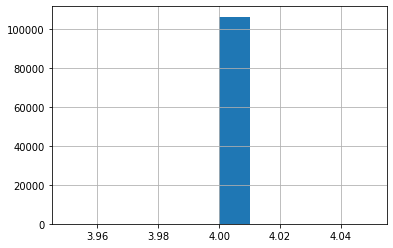

In [25]:
dfPredicted = pd.DataFrame({"Predict": test_predicted})
dfPredicted['Predict'].hist(bins=10)


In [26]:
mae = mean_absolute_error(dfValiTarget, test_predicted)

print("Average MAE: " + str(mae))
print("analyse_maes.append(" + str(mae) + ")")

Average MAE: 0.46286486587952613
analyse_maes.append(0.46286486587952613)


In [27]:

print("Run: " + filePrefix)
# Log of Results
analyse_maes = []
analyse_maes.append(0.44561029386667883)

print("Average MAE over all tests: " + str(np.mean(analyse_maes)))

# Make sure it's predicting floats
# dfPredicted["Predict"].drop_duplicates()

Run + A3_06_lgbm_basicregression_feats_tinker
Average MAE over all tests: 0.44561029386667883


# Results of Runs

File: 200k
Possible Columns: BreweryID, ABV, Beer Type, DayOfWeek, Month, Year, Time of Day (in sec), Gender

These are all without DayofMonth
* ABV, Beer Type (From Basic Regression) MAE: 0.44852097367102955
* All Cols except brewer: 0.4483903262744929
* All Cols minus brewer and beer type: 0.4620847607915829
* All Cols: 0.44561029386667883
* Just Brewery, Year and Beer Type:  0.44538233646964837
* Just Brewery, Year, Beer Type and ABV: 0.44561029386667883
* Just Brewery and Beer Type:  0.44538233646964837

Added DayOfMonth
* All Columns: 0.44561029386667883
* Beer context + ABV (Brewery, Beer Type, ABV) : 0.44561029386667883
* Beer Context Brewery and Beer Type:  0.44538233646964837
* Consumer Context (DayOfWeek, Month, Year, Time of Day (in sec), Gender): 0.46286486587952613

File: 500k (no DayofMonth
* All Cols: 0.4656715581037993
* Just Brewery, Year, Beer Type and ABV: 0.4656715581037993
Exactly the same? weird


Write to a subrun file

In [28]:
dfPredicted = pd.concat([dfValiIds.reset_index(), dfPredicted], axis=1).drop(columns="index")

if writeSubRunFile:
  dfPredicted.to_csv(subrunDir + filePrefix + "_subrun.csv", index=False)

print("Average MAE: " + str(mae))
print(dfPredicted.shape)
dfPredicted.sort_values("RowID").head(20)


Average MAE: 0.46286486587952613
(106546, 4)


,RowID,BeerID,ReviewerID,Predict
0,19,12300,10635,4.0
1,21,12300,6547,4.0
2,23,12300,9789,4.0
3,24,12300,7372,4.0
4,25,12300,1302,4.0
5,26,12300,704,4.0
6,29,12300,1747,4.0
7,31,12300,9368,4.0
8,32,12300,2568,4.0
9,33,12300,6838,4.0
